In [1]:
import VariationalBayes as vb

from VariationalBayes.Parameters import convert_vector_to_free_hessian

# from VariationalBayes.ParameterDictionary import ModelParamsDict
# from VariationalBayes import PosDefMatrixParam, PosDefMatrixParamVector
# from VariationalBayes import SimplexParam

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import copy
from copy import deepcopy
import scipy as sp
from scipy.sparse.linalg import LinearOperator
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
n_num = 100

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

true_z = np.random.multinomial(1, true_pi, n_num)
true_z_ind = np.full(n_num, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x = np.array([ np.random.multivariate_normal(true_mu[true_z_ind[n]], true_sigma[true_z_ind[n]]) \
               for n in range(n_num) ])


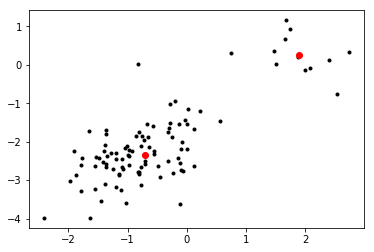

In [3]:
# Never a bad idea to visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [4]:
global_params = vb.ModelParamsDict('global')
global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = vb.ModelParamsDict('local')
local_params.push_param(
    vb.SimplexParam(name='e_z', shape=(n_num, k_num),
                    val=np.full(true_z.shape, 1. / k_num)))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    
init_par_vec = params.get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.61177594  0.79390327]
 [ 0.4567483   0.97602364]]
	pi: [[ 0.5  0.5]]


In [5]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [6]:
def get_info_logdet_array(info):
    return np.array([ np.linalg.slogdet(info[k, :, :])[1] for k in range(info.shape[0]) ])

# This is the log probability of each observation for each component.
def loglik_obs_by_k(mu, info, pi, x):
    log_lik = \
        -0.5 * np.einsum('ni, kij, nj -> nk', x, info, x) + \
               np.einsum('ni, kij, kj -> nk', x, info, mu) + \
        -0.5 * np.expand_dims(np.einsum('ki, kij, kj -> k', mu, info, mu), axis=0)

    logdet_array = np.expand_dims(get_info_logdet_array(info), axis=0)
    log_pi = np.log(pi)

    log_lik += 0.5 * logdet_array + log_pi
    
    return log_lik


In [7]:
def mu_prior(mu, mu_prior_mean, mu_prior_info):
    k_num = mu.shape[0]
    d_num = len(mu_prior_mean)
    assert mu.shape[1] == d_num
    assert mu_prior_info.shape[0] == d_num
    assert mu_prior_info.shape[1] == d_num
    mu_prior_val = 0.0
    for k in range(k_num):
        mu_centered = mu[k, :] - mu_prior_mean
        mu_prior_val += -0.5 * np.matmul(np.matmul(mu_centered, mu_prior_info), mu_centered)
    return mu_prior_val
    
def pi_prior(pi, alpha):
    return np.sum(alpha * np.log(pi))

def info_prior(info, dof):
    k_num = info.shape[0]
    d_num = info.shape[1]
    assert d_num == info.shape[2]
    assert dof > d_num - 1
    # Not a complete Wishart prior
    # TODO: cache the log determinants.
    info_prior_val = 0.0
    for k in range(k_num):
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        info_prior_val += 0.5 * (dof - d_num - 1) * logdet
    return info_prior_val

# TODO: put this in a library
def multinoulli_entropy(e_z):
    return -1 * np.sum(e_z * np.log(e_z))

def get_sparse_multinoulli_entropy_hessian(e_z_vec):
    k = len(e_z_vec)
    vals = -1. / e_z_vec
    return sp.sparse.csr_matrix((vals, ((range(k)), (range(k)))), (k, k))

weights = np.full((n_num, 1), 1.0)
e_z = params['local']['e_z'].get()
mu_prior(true_mu, mu_prior_mean, mu_prior_info)
pi_prior(true_pi, 2.0)
info_prior(true_info, d_num + 2)
multinoulli_entropy(e_z)

get_multinoulli_entropy_hessian = autograd.hessian(multinoulli_entropy)
e_z0 = e_z[0, :]

print(np.max(np.abs(
    get_multinoulli_entropy_hessian(e_z0) - get_sparse_multinoulli_entropy_hessian(e_z0).toarray())))

0.0


In [8]:

class Model(object):
    def __init__(self, x, params, prior_params):
        self.x = x
        self.params = deepcopy(params)
        self.prior_params = deepcopy(prior_params)
        self.weights = np.full((x.shape[0], 1), 1.0)

        # Autograd derivatives
        self.kl_free_grad = autograd.grad(self.kl_free)
        self.kl_free_hessian = autograd.hessian(self.kl_free) # This will be slow.
        self.kl_free_hvp = autograd.hessian_vector_product(self.kl_free)

        self.kl_free_global_grad = autograd.grad(self.kl_free_global)
        self.kl_free_global_hessian = autograd.hessian(self.kl_free_global)
        self.kl_free_global_hvp = autograd.hessian_vector_product(self.kl_free_global)

        self.get_z_nat_params = autograd.grad(self.loglik_e_z)

        self.get_moment_jacobian = autograd.jacobian(self.get_interesting_moments)
        
        self.kl_vector_global_jac = autograd.jacobian(self.kl_vector_global_local, argnum=0)
        self.kl_vector_global_hessian = autograd.hessian(self.kl_vector_global_local, argnum=0)
        self.kl_vector_global_local_hessian = autograd.jacobian(self.kl_vector_global_jac, argnum=1)

        self.kl_vector_jac = autograd.jacobian(self.kl_vector)
        self.kl_vector_hessian = autograd.hessian(self.kl_vector)

    def loglik_obs_by_k(self):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()        
        return loglik_obs_by_k(mu, info, pi, self.x)

    # This needs to be defined so we can differentiate it for CAVI.
    def loglik_e_z(self, e_z):
        return np.sum(e_z * self.loglik_obs_by_k())

    def loglik(self):
        e_z = self.params['local']['e_z'].get()
        return self.loglik_e_z(e_z)

    def loglik_obs(self):
        log_lik_array = self.loglik_obs_by_k()
        e_z = self.params['local']['e_z'].get()
        return np.sum(log_lik_array * e_z, axis=1)    

    def prior(self):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()        
        mu_prior_mean = self.prior_params['mu_prior_mean'].get()
        mu_prior_info = self.prior_params['mu_prior_info'].get()
        prior = 0.
        prior += mu_prior(mu, mu_prior_mean, mu_prior_info)
        prior += pi_prior(pi, self.prior_params['alpha'].get())
        prior += info_prior(info, self.prior_params['dof'].get())
        return prior
    
    def optimize_z(self):
        # Take a CAVI step on Z.
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()
        e_z = self.params['local']['e_z'].get()

        natural_parameters = self.get_z_nat_params(e_z)
        z_logsumexp = np.expand_dims(sp.misc.logsumexp(natural_parameters, 1), axis=1)
        e_z = np.exp(natural_parameters - z_logsumexp)
        self.params['local']['e_z'].set(e_z)
    
    def kl(self, include_local_entropy=True):
        elbo = self.prior() + self.loglik()

        if include_local_entropy:
            e_z = self.params['local']['e_z'].get()
            elbo += multinoulli_entropy(e_z)
        
        return -1 * elbo
    

    #######################
    # Moments for sensitivity
    
    def get_interesting_moments(self, free_params):
        self.params.set_free(free_params)
        return self.params['global']['mu'].get_vector()

    ######################################
    # Compute sparse hessians by hand.

    # Log likelihood by data point.
    
    # The rows are the z vector indices and the columns are the data points.
    def loglik_vector_local_weight_hessian_sparse(self):
        log_lik_array = self.loglik_obs_by_k()

        hess_vals = [] # These will be the entries of dkl / dz dweight^T
        hess_rows = [] # These will be the z indices
        hess_cols = [] # These will be the data indices
        # This is the Hessian of the negative entropy, which enters the KL divergence.
        for row in range(e_z.shape[0]):
            z_row_inds = self.params['local']['e_z'].get_vector_indices(row)
            for col in range(e_z.shape[1]):
                hess_vals.append(log_lik_array[row, col])
                hess_rows.append(z_row_inds[col])
                hess_cols.append(row)

        local_size = self.params['local']['e_z'].vector_size()
        return sp.sparse.csr_matrix((hess_vals, (hess_rows, hess_cols)),
                                     (local_size, self.x.shape[0]))

    # KL
    def kl_vector_local_hessian_sparse(self):
        e_z = self.params['local']['e_z'].get()
        hess_vals = []
        hess_rows = []
        # This is the Hessian of the negative entropy, which enters the KL divergence.
        for row in range(e_z.shape[0]):
            # Note that we are relying on the fact that the local parameters
            # only contain e_z, so the vector index in e_z is the vector index
            # in the local parameters.
            row_inds = self.params['local']['e_z'].get_vector_indices(row)
            for col in range(e_z.shape[1]):
                hess_vals.append(1. / e_z[row, col])
                hess_rows.append(row_inds[col])
        local_size = self.params['local']['e_z'].vector_size()
        return sp.sparse.csr_matrix((hess_vals, (hess_rows, hess_rows)),
                                    (local_size, local_size))

    ######################
    ######################
    # Everything below here should be boilerplate.
    
    def loglik_free_local_weight_hessian_sparse(self):
        free_par_local = self.params['local'].get_free()
        free_to_vec_jac = self.params['local'].free_to_vector_jac(free_par_local) 
        return free_to_vec_jac .T * \
               self.loglik_vector_local_weight_hessian_sparse()

    def loglik_free_weight_hessian_sparse(self):
        get_loglik_obs_free_global_jac = \
            autograd.jacobian(self.loglik_obs_free_global_local, argnum=0)
        loglik_obs_free_global_jac = \
            get_loglik_obs_free_global_jac(self.params['global'].get_free(),
                                           self.params['local'].get_free()).T
        loglik_obs_free_local_jac = \
            self.loglik_free_local_weight_hessian_sparse()

        return sp.sparse.vstack([ loglik_obs_free_global_jac, loglik_obs_free_local_jac ])
    
    def kl_vector_hessian_sparse(self):
        global_vec = self.params['global'].get_vector()
        local_vec = self.params['local'].get_vector()
    
        global_hess = self.kl_vector_global_hessian(global_vec, local_vec)
        global_local_hess = self.kl_vector_global_local_hessian(global_vec, local_vec)
        local_hess_sparse = self.kl_vector_local_hessian_sparse()
        sp_hess =  sp.sparse.bmat([ [global_hess,         global_local_hess],
                                    [global_local_hess.T, local_hess_sparse]])
        return np.array(sp_hess.toarray())
    

    # This takes free_params as an argument so it can be used in optimization.
    def kl_free_hessian_sparse(self, free_params):
        self.params.set_free(free_params)
        kl_vector_hessian_sparse = self.kl_vector_hessian_sparse()
        kl_vector_jac = self.kl_vector_jac(self.params.get_vector())
        kl_hessian_sparse = convert_vector_to_free_hessian(
            self.params, free_params, kl_vector_jac, kl_vector_hessian_sparse)

        # If you don't convert to an array, it returns a matrix type, which
        # seems to cause mysterious problems with scipy.optimize.minimize.
        return np.array(kl_hessian_sparse)

    # Wrappers for autodiff follow. The nomeclature is
    # {function}_{free | vector}_{|global|local}_{|sparse}

    def kl_free(self, free_params, verbose=False):
        self.params.set_free(free_params)
        kl = self.kl()
        if verbose:
            print(kl)
        return kl

    def kl_free_global(self, global_free_params, verbose=False):
        self.params['global'].set_free(global_free_params)
        kl = self.kl(include_local_entropy=False)
        if verbose:
            print(kl)
        return kl

    def kl_vector_global_local(self, global_vec_params, local_vec_params,
                               verbose=False, include_local_entropy=True):
        self.params['global'].set_vector(global_vec_params)
        self.params['local'].set_vector(local_vec_params)
        kl = self.kl(include_local_entropy=include_local_entropy)
        if verbose:
            print(kl)
        return kl

    def kl_vector(self, vec_params, 
                  verbose=False, include_local_entropy=True):
        self.params.set_vector(vec_params)
        kl = self.kl(include_local_entropy=include_local_entropy)
        if verbose:
            print(kl)
        return kl
    
    def loglik_obs_free_global_local(self, free_params_global, free_params_local):
        self.params['global'].set_free(free_params_global)
        self.params['local'].set_free(free_params_local)
        return self.loglik_obs()


In [14]:
model = Model(x, params, prior_params)
model.optimize_z()

free_par = params.get_free()
vec_par = params.get_vector()

global_free_par = params['global'].get_free()
model.kl_free(free_par)

grad = obj.kl_free_grad(free_par)

hvp_time = time.time()
hvp = model.kl_free_hvp(free_par, grad)
hvp_time = time.time() - hvp_time

grad = model.kl_free_global_grad(global_free_par)
hvp = model.kl_free_global_hvp(global_free_par, grad)

# Not as slow!  You can ignore the autograd warning.
sparse_hess_time = time.time()
sparse_hessian = model.kl_free_hessian_sparse(free_par)
sparse_hess_time = time.time() - sparse_hess_time

print('Hessian: ', sparse_hess_time)
print('Hessian vector product', hvp_time)

/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Hessian:  0.5805191993713379
Hessian vector product 0.020444869995117188


In [15]:
# Check the weight Jacobians.
get_loglik_obs_free_local_jac = \
    autograd.jacobian(obj.loglik_obs_free_global_local, argnum=1)

free_par_global = obj.params['global'].get_free()
free_par_local = obj.params['local'].get_free()


loglik_obs_free_local_jac = \
    get_loglik_obs_free_local_jac(free_par_global, free_par_local)

loglik_vector_local_weight_hessian_sparse = \
    obj.loglik_vector_local_weight_hessian_sparse()

likelihood_by_obs_free_local_jac_sparse = \
    obj.loglik_free_local_weight_hessian_sparse()

print(obj.x.shape)
print(likelihood_by_obs_free_local_jac_sparse.shape)
print(loglik_vector_local_weight_hessian_sparse.shape)
print(np.max(np.abs(loglik_obs_free_local_jac - likelihood_by_obs_free_local_jac_sparse)))


(100, 2)
(100, 100)
(200, 100)
8.881784197e-16


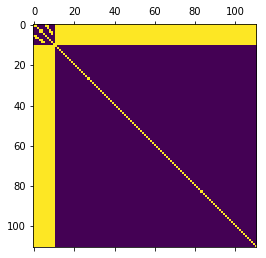

In [16]:
if True:
    # Compare the full and sparse Hessians
    kl_vector_hessian = autograd.hessian(model.kl_vector)
    hessian = model.kl_free_hessian(free_par) # Slow
    vector_hessian = kl_vector_hessian(vec_par)  # Slow

    # The slow full Hessian and sparse Hessian agree.
    plt.matshow(sparse_hessian != 0)
    assert np.max(np.abs(hessian - sparse_hessian)) < 1e-8


In [17]:
# Perform EM.

model.params.set_free(init_par_vec)
model.optimize_z()
global_param_vec = model.params['global'].get_vector()
kl = model.kl()

for step in range(20):
    global_free_par = model.params['global'].get_free()

    # Different choices for the M step:
    global_vb_opt = optimize.minimize(
       lambda par: model.kl_free_global(par, verbose=False),
       x0=global_free_par, jac=model.kl_free_global_grad, hessp=model.kl_free_global_hvp,
       method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-2})
    #global_vb_opt = optimize.minimize(
    #    lambda par: model.global_kl_wrapper(par, verbose=False),
    #    x0=global_free_par, jac=model.global_kl_grad, hess=model.global_kl_hessian,
    #    method='trust-ncg', options={'maxiter': 50})
    #global_vb_opt = optimize.minimize(
    #   lambda par: model.global_kl_wrapper(par, verbose=False),
    #   x0=global_free_par, method='nelder-mead', options={'maxiter': 500})
    #global_vb_opt = optimize.minimize(
    #   lambda par: model.global_kl_wrapper(par, verbose=False),
    #  x0=global_free_par, method='bfgs', options={'maxiter': 50})
    model.params['global'].set_free(global_vb_opt.x)

    # E-step:
    model.optimize_z()

    new_global_param_vec = model.params['global'].get_vector()
    diff = np.max(np.abs(new_global_param_vec - global_param_vec))
    global_param_vec = deepcopy(new_global_param_vec)
    
    new_kl = model.kl()
    kl_diff = new_kl - kl
    kl = new_kl
    print(' kl: {}\t\tkl_diff = {}\t\tdiff = {}'.format(kl, kl_diff, diff))
    if diff < 1e-6:
        break

em_free_par = model.params.get_free()
print('Done.')


 kl: 65.5216754166816		kl_diff = -531.1452016537255		diff = 2.9603594160961695
 kl: 65.46763493014835		kl_diff = -0.05404048653325333		diff = 0.029041830790111245
 kl: 65.33602121578957		kl_diff = -0.1316137143587781		diff = 0.05166484062981569
 kl: 64.92132540583609		kl_diff = -0.41469580995348565		diff = 0.09813716572296105
 kl: 63.40216845957899		kl_diff = -1.5191569462570982		diff = 0.187735203424237
 kl: 57.77525546736068		kl_diff = -5.626912992218308		diff = 0.3346201069196626
 kl: 45.73827134027532		kl_diff = -12.036984127085361		diff = 0.7453020334874485
 kl: 41.01192831660232		kl_diff = -4.726343023672996		diff = 0.6178020387956238
 kl: 40.05448100916955		kl_diff = -0.9574473074327727		diff = 0.21655497078016595
 kl: 39.809925123142705		kl_diff = -0.24455588602684486		diff = 0.0787575294840751
 kl: 39.72194765120244		kl_diff = -0.08797747194026329		diff = 0.04939892878594093
 kl: 39.66905155915344		kl_diff = -0.052896092049003585		diff = 0.03713977051509243
 kl: 39.62558282894

In [18]:
# Finish with one joint Newton optimization to ensure global optimality.
# vb_opt = optimize.minimize(
#     lambda par: model.kl_free(par, verbose=True),
#     x0=em_free_par, jac=model.kl_free_grad, hessp=model.kl_free_hvp,
#     method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

# print('Done')
# model.params.set_free(vb_opt.x)

# Newton is faster than CG if you go to high-quality optimum.
vb_opt = optimize.minimize(
    lambda par: model.kl_free(par, verbose=True),
    x0=em_free_par, jac=model.kl_free_grad, hess=model.kl_free_hessian_sparse,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('done')
print(model.kl_free(vb_opt.x))

/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


39.3501201608
39.330611485
39.3241650965
39.2587946368
39.2391470818
39.1238272875
39.0585393562
39.0558843488
38.8068466782
38.7268642099
38.7153348132
38.5329977187
37.7810221208
37.5194120653
37.4947279562
37.4850944341
35.9052393808
35.2993122141
35.204735649
35.1855735601
50.5103709927
34.3124814265
33.8708849342
33.8662323466
33.8633616531
33.2635544809
32.7721457319
32.6204678923
32.5606235305
32.745120953
32.4527199113
32.4443104288
32.4344778331
32.2958869377
32.2879146489
32.2877750485
32.2279252988
32.227667879
32.2060679487
32.2060349267
38.1941094041
32.2027951112
32.2014717615
32.2012474319
32.2020908859
32.1998064906
32.199582017
32.1976308354
32.1974003764
32.1952537704
32.1952403798
done
32.1952403798


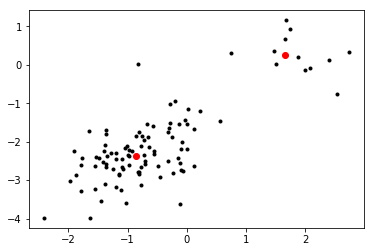

In [19]:
# Check that the solution looks sensible.
mu_fit = model.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [20]:
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

moment_jac = model.get_moment_jacobian(vb_opt.x)

kl_free_hessian_sparse = model.kl_free_hessian_sparse(vb_opt.x)
sensitivity_operator = \
    sp.sparse.linalg.spsolve(csc_matrix(kl_free_hessian_sparse),
                             csr_matrix(moment_jac).T)


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [21]:
weight_jac = model.loglik_free_weight_hessian_sparse()
data_sens = (weight_jac.T * sensitivity_operator).toarray()
print(data_sens.shape)

(100, 4)


In [24]:
rm_row = 3
keep_rows = np.setdiff1d(np.arange(model.x.shape[0]), rm_row)
model.params.set_free(vb_opt.x)

e_z_rm = vb.SimplexParam(name='e_z', shape=(n_num - 1, k_num))
e_z_rm.set(model.params['local']['e_z'].get()[keep_rows, :])
rm_local = vb.ModelParamsDict('local')
rm_local.push_param(e_z_rm)

rm_params = vb.ModelParamsDict('mixture model deleted row')
rm_params.push_param(model.params['global'])
rm_params.push_param(rm_local)

rm_model = Model(x[keep_rows, :], rm_params, prior_params)

In [ ]:
init_par = rm_model.params.get_free()

rm_model.kl_free(init_par)
rm_model.kl_free_hessian_sparse(init_par)

# Finish with one joint Newton optimization to ensure global optimality.
# rm_vb_opt = optimize.minimize(
#     lambda par: rm_model.kl_free(par, verbose=True),
#     x0=init_par, jac=rm_model.kl_free_grad, hessp=rm_model.kl_free_hvp,
#     method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

rm_vb_opt = optimize.minimize(
    lambda par: rm_model.kl_free(par, verbose=True),
    x0=init_par, jac=rm_model.kl_free_grad, hess=rm_model.kl_free_hessian_sparse,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('Done')
rm_model.params.set_free(rm_vb_opt.x)


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [ ]:

print('Actual sensitivity:\t', 
      rm_model.get_interesting_moments(rm_vb_opt.x) - model.get_interesting_moments(vb_opt.x))
print('Predicted sensitivity:\t', -1 * data_sens[rm_row, :])
